In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
# PROJECT_ROOT_DIR = "."
# CHAPTER_ID = "autoencoders"

# def save_fig(fig_id, tight_layout=True):
#     path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
#     print("Saving figure", fig_id)
#     if tight_layout:
#         plt.tight_layout()
#     plt.savefig(path, format='png', dpi=300)

In [2]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

In [3]:
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

In [4]:
import tensorflow as tf

自动编码器是能够在无需任何监督(例如，训练数据没有任何标记)的情况下学习有效表示输入数据(称为编码)的人工神经网络。可以用来降维、深层神经网络的无监督训练，最后能够生产与训练数据非常近似的新数据，这被称为生成模型。

可以通过限制内部表示的尺寸，或者向输入添加噪音并训练网络恢复原始输入，来限制自动编码器直接将输入复制到输出。简而言之，编码是自动编码器在尝试在某些限制下学习认证方法的附属品。

本章将深入介绍自动编码器的工作原理，可以什么类型的约束，以及如何使用TensorFlow实现它们，无论是用于降噪、特征提取、无监督预训练，还是生成模型。

# 高效的数据显示

有规律的信息比无规律的信息更容易记住，这使得识别模式变得很有用，这也澄清了为什么在训练期间限制自动编码器促使它发现和利用了数据中的模式。

自动编码器的输出和查看，将它们转化为有效的内部表示，然后输出一些看起来和输入很像的东西。一个自动编码器总是由两部分组成：第一部分是将输入转化为内部表示的编码器(或者被称为识别网络),第二部分是将内部表示转换为输出的编码器(或者称为生成网络).

自动编码器通常和多层感知器具有相同的架构，不同之处在于自动编码器的输出层的神经元数量必须等于输入层的数量。

# 使用不完整的线性自动编码器实现PCA

如果自动编码器仅使用线性激活，并且成本函数是均方差(MSE)，则表示它可以用来实现主要组件分析。

构建数据集，(和第八章的数据一样)

In [5]:
import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

标准化

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

构建一层隐层的编码器

In [7]:
reset_graph()

n_inputs = 3
n_hidden = 2  # codings
n_outputs = n_inputs # 输出和输入一样

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


In [11]:
n_iterations = 1000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X: X_test})
    X3D_inv=outputs.eval(feed_dict={X: X_test})

可以看到，自动编码器找到了一个比较好的2D平台来展现数据，尽可能多的保留数据的差异性.

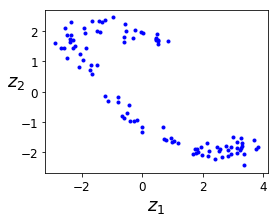

In [12]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.show()

In [14]:
X3D_inv.shape

(100, 3)

In [16]:
X_train.shape

(100, 3)

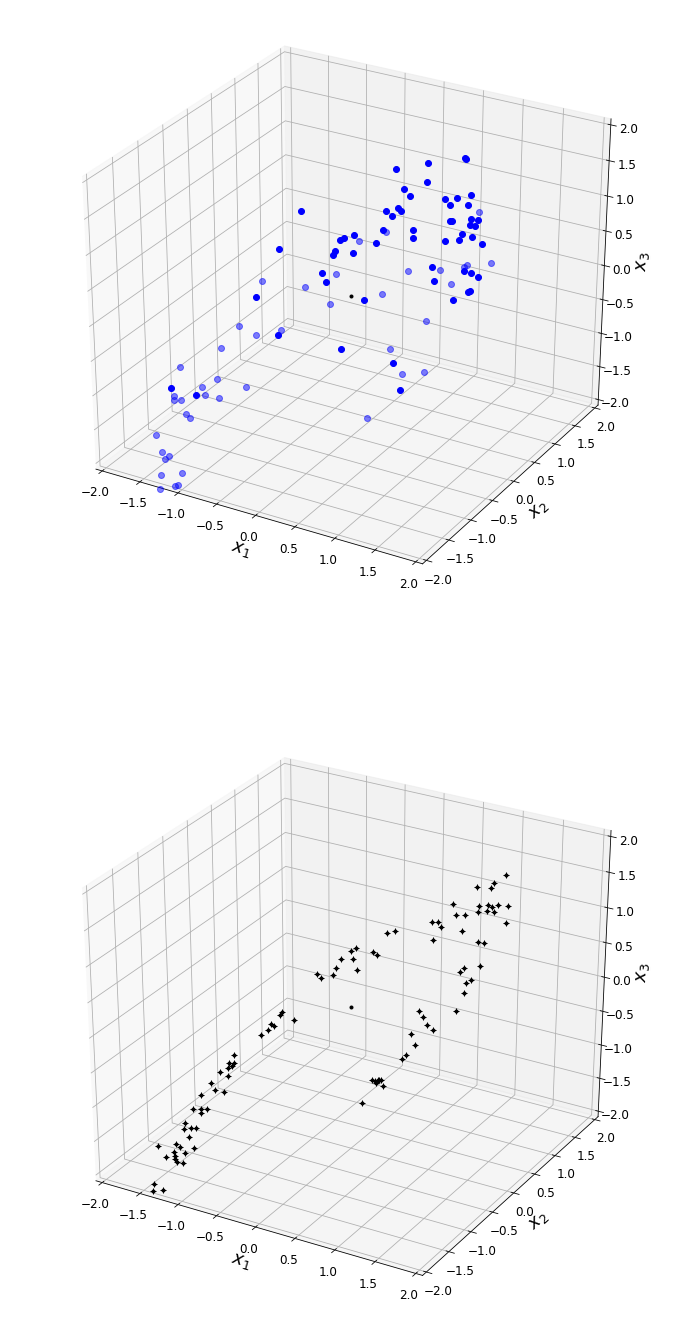

In [34]:
from mpl_toolkits.mplot3d import Axes3D
axes = [-2, 2, -2, 2, -2, 2]
fig = plt.figure(figsize=(12, 24))
ax = fig.add_subplot(211, projection='3d')

X3D_above = X_train[X_train[:, 2] > X3D_inv[:, 2]]
X3D_below = X_train[X_train[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

# ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
# np.linalg.norm(C, axis=0)
# ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
# ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

# for i in range(100):
#     if X_train[i, 2] > X3D_inv[i, 2]:
#         ax.plot([X_train[i][0], X3D_inv[i][0]], [X_train[i][1], X3D_inv[i][1]], [X_train[i][2], X3D_inv[i][2]], "k-")
#     else:
#         ax.plot([X_train[i][0], X3D_inv[i][0]], [X_train[i][1], X3D_inv[i][1]], [X_train[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
# ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
# ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# Note: If you are using Matplotlib 3.0.0, it has a bug and does not
# display 3D graphs properly.
# See https://github.com/matplotlib/matplotlib/issues/12239
# You should upgrade to a later version. If you cannot, then you can
# use the following workaround before displaying each 3D graph:
# for spine in ax.spines.values():
#     spine.set_visible(False)

# save_fig("dataset_3d_plot")
ax = fig.add_subplot(212, projection='3d')
# X3D_above = X_train[X_train[:, 2] > X3D_inv[:, 2]]
# X3D_below = X_train[X_train[:, 2] <= X3D_inv[:, 2]]

# ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

# ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
# np.linalg.norm(C, axis=0)
# ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
# ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

# for i in range(100):
#     if X_train[i, 2] > X3D_inv[i, 2]:
#         ax.plot([X_train[i][0], X3D_inv[i][0]], [X_train[i][1], X3D_inv[i][1]], [X_train[i][2], X3D_inv[i][2]], "k-")
#     else:
#         ax.plot([X_train[i][0], X3D_inv[i][0]], [X_train[i][1], X3D_inv[i][1]], [X_train[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
# ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.show()

# 栈式自动编码器

自动编码器也可以有多个隐藏层，这种情况下，被称为栈式自动编码器(又被称为深度自动编码器)。

栈式自动编码器的结构通常对称于中央隐藏层(编码层),构成三明治结构。

## TensorFlow实现

In [35]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("D:\data")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting D:\data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting D:\data\train-labels-idx1-ubyte.gz
Extracting D:\data\t10k-images-idx3-ubyte.gz
Extracting D:\data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


三明治结构 784->300->150->300->784

In [36]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init = tf.contrib.layers.variance_scaling_initializer() # He initialization
#Equivalent to:
#he_init = lambda shape, dtype=tf.float32: tf.truncated_normal(shape, 0., stddev=np.sqrt(2/shape[0]))
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
# 使用 elu he_init初始化 l2正则
my_dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.elu,
                         kernel_initializer=he_init,
                         kernel_regularizer=l2_regularizer)

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
# 获取正则化结果
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver() # not shown in the book

In [37]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()                                          # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})   # not shown
        print("\r{}".format(epoch), "Train MSE:", loss_train)           # not shown
        saver.save(sess, "./my_model_all_layers.ckpt")                  # not shown

0 Train MSE: 0.021055847
1 Train MSE: 0.011427504
2 Train MSE: 0.010220435
3 Train MSE: 0.009907863
4 Train MSE: 0.010376671


展现编码结果

In [38]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

可以看到，输入的数据编码之后，解码的结果还是很不错的

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt


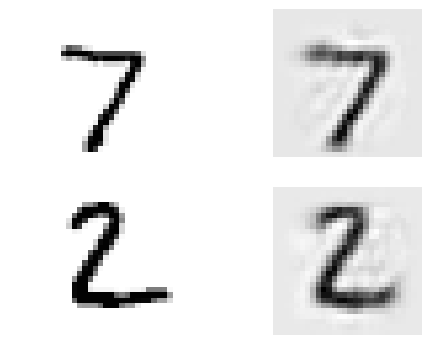

In [39]:
show_reconstructed_digits(X, outputs, "./my_model_all_layers.ckpt")

## 权重绑定

当自动编码器和我们刚刚构建的那样严格对称时，一种常见的技术是将解码层的权重和编码层的权重联系起来，这种方式将模型的权重参数减半，提高训练速度，限制了过度配置的风险。遗憾的是，TensorFlow的内置函数实现这样的操作比较复杂。

In [40]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [41]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
# 绑定 784->300  300->150  并且转置
weights3 = tf.transpose(weights2, name="weights3")  # tied weights
weights4 = tf.transpose(weights1, name="weights4")  # tied weights

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [42]:
saver = tf.train.Saver()

In [43]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_tying_weights.ckpt")

0 Train MSE: 0.01506695
1 Train MSE: 0.016488748
2 Train MSE: 0.017375939
3 Train MSE: 0.016878333
4 Train MSE: 0.015587721


INFO:tensorflow:Restoring parameters from ./my_model_tying_weights.ckpt


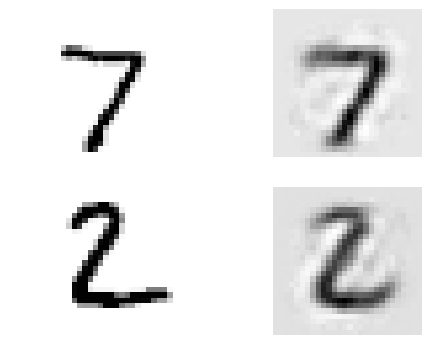

In [44]:
show_reconstructed_digits(X, outputs, "./my_model_tying_weights.ckpt")

## 一次训练一个自动编码器

相比于像我们这样一次训练整个栈式自动编码器，一次训练一个单独的自动编码器会快很多，然后将他们堆叠为一个栈式自动编码器。

在学习的第一个阶段，第一个自动编码器学习重现输入。在第二阶段，第二个自动编码器学习重建第一个自动编码器隐藏层的输出，最终，用这些所有的自动编码器构建了一个大三明治。用这种方式，可以轻松地训练更多的自动编码器，然后构建一个非常深层的栈式自动编码器。】

为了实现这种多阶段训练算法，最简单的方法是对每个阶段使用不同的TensorFlow图，另一种方法是使用一个包含栈式自动编码器的单个图表。

### 先使用第一种方法训练

In [45]:
reset_graph()

from functools import partial

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                      learning_rate = 0.01, l2_reg = 0.0005, seed=42,
                      hidden_activation=tf.nn.elu,
                      output_activation=tf.nn.elu):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)

        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))

        hidden = my_dense_layer(X, n_neurons, activation=hidden_activation, name="hidden")

        outputs = my_dense_layer(hidden, n_inputs, activation=output_activation, name="outputs")

        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X: X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

In [46]:
# 训练输入到输出
hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images, n_neurons=300, n_epochs=4, batch_size=150,
                                                  output_activation=None)
# 训练重建第一个自动编码器隐藏层的输出
_, W2, b2, W3, b3 = train_autoencoder(hidden_output, n_neurons=150, n_epochs=4, batch_size=150)

0 Train MSE: 0.01851794
1 Train MSE: 0.01868272
2 Train MSE: 0.018467719
3 Train MSE: 0.019231746
0 Train MSE: 0.004236093
1 Train MSE: 0.0048326333
2 Train MSE: 0.004668708
3 Train MSE: 0.004403875


In [47]:
reset_graph()

n_inputs = 28*28

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

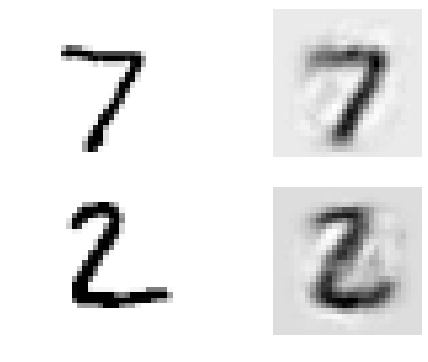

In [48]:
show_reconstructed_digits(X, outputs)

### 第二种方法

In [49]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [50]:
optimizer = tf.train.AdamOptimizer(learning_rate)
# 优化 输出和输入的损失
with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4  # bypass hidden2 and hidden3
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)
# 优化 隐藏层1和隐藏层3的损失
with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars) # freeze hidden1

In [51]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [52]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            loss_train = reconstruction_losses[phase].eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./my_model_one_at_a_time.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)

Training phase #1
0 %Train MSE: 0.007406866
1 Train MSE: 0.0078288205
2 Train MSE: 0.007728097
3 Train MSE: 0.0074090064
Training phase #2
0 Train MSE: 0.35758996
1 Train MSE: 0.00593613
2 Train MSE: 0.0030089526
3 Train MSE: 0.0024365915
Test MSE: 0.009815396


INFO:tensorflow:Restoring parameters from ./my_model_one_at_a_time.ckpt


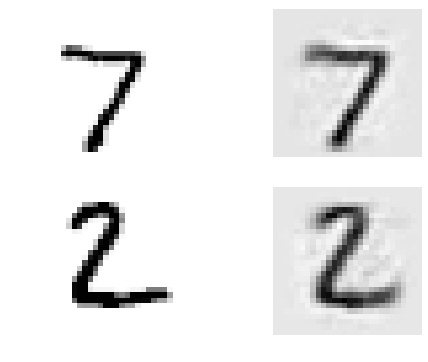

In [54]:
show_reconstructed_digits(X, outputs, "./my_model_one_at_a_time.ckpt")

第二种方法改进缓存冻结层的输出，提高训练速度

In [55]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        if phase == 1:
            hidden1_cache = hidden1.eval(feed_dict={X: mnist.train.images})
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                if phase == 1:
                    indices = rnd.permutation(mnist.train.num_examples)
                    hidden1_batch = hidden1_cache[indices[:batch_sizes[phase]]]
                    feed_dict = {hidden1: hidden1_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
                else:
                    X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                    feed_dict = {X: X_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
            loss_train = reconstruction_losses[phase].eval(feed_dict=feed_dict)
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./my_model_cache_frozen.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)

Training phase #1
09% Train MSE: 0.0075382586
1 Train MSE: 0.007754701
2 Train MSE: 0.007343679
3 Train MSE: 0.007837775
Training phase #2
0 Train MSE: 0.18597357
19% Train MSE: 0.0044647465
29% Train MSE: 0.002462252
3 Train MSE: 0.0020415403
Test MSE: 0.009790834


## 重建可视化

保证自动编码器被适当训练的一种方法是比较输入和输出，它们必须相当相似，差异性应该是一些不重要的细节，我们来绘制两个随机数字及其重建。

INFO:tensorflow:Restoring parameters from ./my_model_one_at_a_time.ckpt


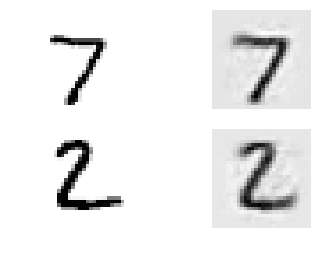

In [56]:
n_test_digits = 2
X_test = mnist.test.images[:n_test_digits]

with tf.Session() as sess:
    saver.restore(sess, "./my_model_one_at_a_time.ckpt") # not shown in the book
    outputs_val = outputs.eval(feed_dict={X: X_test})

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])

## 特征可视化

一旦自动编码器学会了某些特征，我们可以会想看看。有各种技术可以做到这一点，其中，最简单的技术是考虑隐藏层的每个神经元，然后找到激活它最多的训练实例。该技术对顶层的隐藏层尤其有效。

我们来看另一种技术，也是我们下面使用的，就是将我们隐藏层神经元的权重输出。

INFO:tensorflow:Restoring parameters from ./my_model_one_at_a_time.ckpt


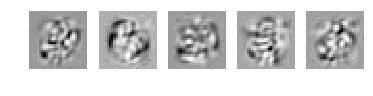

In [57]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_one_at_a_time.ckpt") # not shown in the book
    weights1_val = weights1.eval()

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plot_image(weights1_val.T[i])

# save_fig("extracted_features_plot") # not shown
plt.show()                          # not shown

In [58]:
weights1_val.shape

(784, 300)

In [59]:
weights1_val.T[0].shape

(784,)

另一种技术是向自动编码器馈送随机输入图像，测量我们感兴趣的神经元的激活，然后执行反向传播，以使得神经元激活更多的方式调整图像。

最终，如果使用自动编码器来执行无监督的预训练，比如分类器。一个简单验证自动编码器学习到的特征是否有用的方法是测量分类器的性能。

# 使用堆叠的自动编码器进行无监控的预训练

不加载预训练网络的监督学习

In [66]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_outputs = 10

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.int32, shape=[None])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_outputs), name="biases3")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
logits = tf.matmul(hidden2, weights3) + biases3

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
loss = cross_entropy + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
pretrain_saver = tf.train.Saver([weights1, weights2, biases1, biases2])
saver = tf.train.Saver()

In [67]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end=" ")
        saver.save(sess, "./my_model_supervised.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

0 Train accuracy: 0.97333336 Test accuracy: 0.9334
1 Train accuracy: 0.98 Test accuracy: 0.936
29% Train accuracy: 0.97333336 Test accuracy: 0.9382
3 Train accuracy: 0.9866667 Test accuracy: 0.9489


加载无监督自动编码器的预训练模型参数

深度神经网络可以被无监督的方式预处理，只需要用所有的训练数据训练一个自动编码器，然后复用它的编码层创建一个新的神经网络。

In [68]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

# training_op = optimizer.minimize(loss, var_list=[weights3, biases3])  # Freeze layers 1 and 2 (optional)

with tf.Session() as sess:
    init.run()
    pretrain_saver.restore(sess, "./my_model_cache_frozen.ckpt")
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end="\t")
        saver.save(sess, "./my_model_supervised_pretrained.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

INFO:tensorflow:Restoring parameters from ./my_model_cache_frozen.ckpt
0 Train accuracy: 0.9533333	Test accuracy: 0.9294
1 Train accuracy: 0.96666664	Test accuracy: 0.9342
2 Train accuracy: 0.98	Test accuracy: 0.9449
3 Train accuracy: 0.9866667	Test accuracy: 0.9462


# 去噪自动编码器

另一种强制自动编码器学习有用特征的方式是在输入中增加噪声，训练它以恢复原始无噪声输入。

In [69]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [70]:
noise_level = 1.0

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

hidden1 = tf.layers.dense(X_noisy, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, # not shown in the book
                          name="hidden2")                            # not shown
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, # not shown
                          name="hidden3")                            # not shown
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        # not shown

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

In [71]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [72]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_gaussian.ckpt")

0 Train MSE: 0.04390057
1 Train MSE: 0.04358366
2 Train MSE: 0.0421237
3 Train MSE: 0.04107139
4 Train MSE: 0.04023403
5 Train MSE: 0.03866074
6 Train MSE: 0.039371487
7 Train MSE: 0.042386502
8 Train MSE: 0.039732188
9 Train MSE: 0.04124515


使用dropout，随机打断一些输入。

In [73]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [74]:
dropout_rate = 0.3

training = tf.placeholder_with_default(False, shape=(), name='training')

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, # not shown in the book
                          name="hidden2")                            # not shown
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, # not shown
                          name="hidden3")                            # not shown
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        # not shown

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [75]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [76]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, training: True})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_dropout.ckpt")

0 Train MSE: 0.029571388
1 Train MSE: 0.028672917
2 Train MSE: 0.026254741
3 Train MSE: 0.026573565
4 Train MSE: 0.025833968
5 Train MSE: 0.02608697
6 Train MSE: 0.025375025
7 Train MSE: 0.026003368
8 Train MSE: 0.024490716
9 Train MSE: 0.02453111


INFO:tensorflow:Restoring parameters from ./my_model_stacked_denoising_gaussian.ckpt


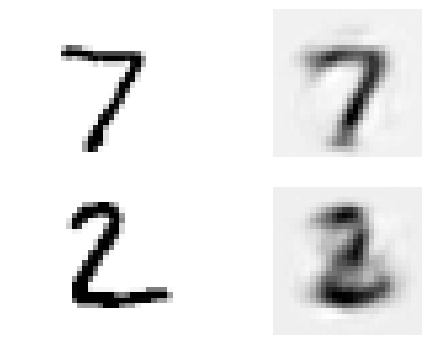

In [78]:
show_reconstructed_digits(X, outputs, "./my_model_stacked_denoising_gaussian.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_stacked_denoising_dropout.ckpt


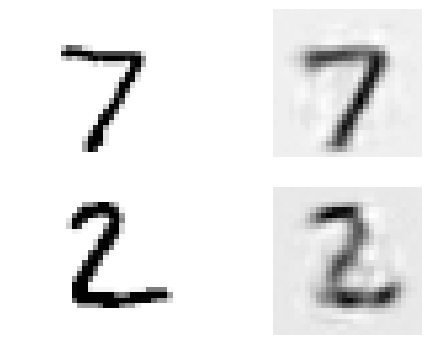

In [79]:
show_reconstructed_digits(X, outputs, "./my_model_stacked_denoising_dropout.ckpt")

# 稀疏自动编码器

另一种导致良好特征提取的约束是稀疏性：通过在成本函数中增加适当的条件，推动自动编码器减小编码层中活动神经元的数量，我们可以通过成本函数添加稀疏性，但是更好的方式是使用KL散度，它比均方差具有更强的梯度。

[0, 1, 0, 0.95]

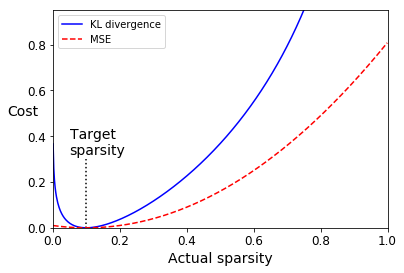

In [80]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mse, "r--", label="MSE")
plt.legend(loc="upper left")
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])

In [81]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 1000  # sparse codings
n_outputs = n_inputs

In [82]:
def kl_divergence(p, q):
    # Kullback Leibler divergence
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

X = tf.placeholder(tf.float32, shape=[None, n_inputs])            # not shown in the book

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid) # not shown
outputs = tf.layers.dense(hidden1, n_outputs)                     # not shown

hidden1_mean = tf.reduce_mean(hidden1, axis=0) # batch mean
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE
loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

Instructions for updating:
Use tf.cast instead.


In [83]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [84]:
n_epochs = 100
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", reconstruction_loss_val, "\tSparsity loss:", sparsity_loss_val, "\tTotal loss:", loss_val)
        saver.save(sess, "./my_model_sparse.ckpt")

0 Train MSE: 0.13819478 	Sparsity loss: 0.4184437 	Total loss: 0.22188354
18% Train MSE: 0.059185907 	Sparsity loss: 0.01074792 	Total loss: 0.061335493
2 Train MSE: 0.053931113 	Sparsity loss: 0.019957254 	Total loss: 0.057922564
3 Train MSE: 0.04771372 	Sparsity loss: 0.039470077 	Total loss: 0.055607736
48% Train MSE: 0.044841796 	Sparsity loss: 0.0115930075 	Total loss: 0.0471604
58% Train MSE: 0.04044193 	Sparsity loss: 0.09246967 	Total loss: 0.058935866
68% Train MSE: 0.03886659 	Sparsity loss: 0.04581166 	Total loss: 0.048028924
7 Train MSE: 0.037868652 	Sparsity loss: 0.074980654 	Total loss: 0.052864783
8 Train MSE: 0.033122517 	Sparsity loss: 0.020321999 	Total loss: 0.037186917
9 Train MSE: 0.031449173 	Sparsity loss: 0.095670156 	Total loss: 0.050583206
10 Train MSE: 0.027398113 	Sparsity loss: 0.06570522 	Total loss: 0.040539157
11% Train MSE: 0.024734963 	Sparsity loss: 0.0888942 	Total loss: 0.042513803
12 Train MSE: 0.023367297 	Sparsity loss: 0.057663042 	Total loss: 

INFO:tensorflow:Restoring parameters from ./my_model_sparse.ckpt


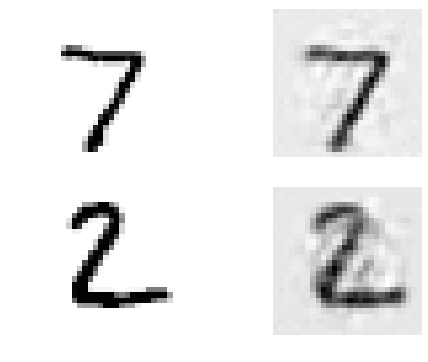

In [85]:
show_reconstructed_digits(X, outputs, "./my_model_sparse.ckpt")

使用交叉熵

In [94]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 1000  # sparse codings
n_outputs = n_inputs

In [95]:
def kl_divergence(p, q):
    # Kullback Leibler divergence
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

X = tf.placeholder(tf.float32, shape=[None, n_inputs])            # not shown in the book

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid) # not shown
logits = tf.layers.dense(hidden1, n_outputs)                     # not shown
outputs = tf.nn.sigmoid(logits)

hidden1_mean = tf.reduce_mean(hidden1, axis=0) # batch mean
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits) # 交叉熵
reconstruction_loss = tf.reduce_mean(xentropy)
loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [96]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [97]:
n_epochs = 100
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train XEN:", reconstruction_loss_val, "\tSparsity loss:", sparsity_loss_val, "\tTotal loss:", loss_val)
        saver.save(sess, "./my_model_sparse_xen.ckpt")

0 Train XEN: 0.28140256 	Sparsity loss: 0.24944562 	Total loss: 0.33129168
1 Train XEN: 0.24832644 	Sparsity loss: 0.056024805 	Total loss: 0.2595314
2 Train XEN: 0.2295421 	Sparsity loss: 0.18378818 	Total loss: 0.26629975
3 Train XEN: 0.19689262 	Sparsity loss: 0.017024068 	Total loss: 0.20029743
4 Train XEN: 0.17197825 	Sparsity loss: 0.010052467 	Total loss: 0.17398874
5 Train XEN: 0.1582938 	Sparsity loss: 0.035690084 	Total loss: 0.16543181
6 Train XEN: 0.145021 	Sparsity loss: 0.096097074 	Total loss: 0.16424042
7 Train XEN: 0.135477 	Sparsity loss: 0.03601439 	Total loss: 0.14267989
8 Train XEN: 0.12727062 	Sparsity loss: 0.041224178 	Total loss: 0.13551547
9 Train XEN: 0.11979294 	Sparsity loss: 0.056493215 	Total loss: 0.13109158
10 Train XEN: 0.115541965 	Sparsity loss: 0.09306923 	Total loss: 0.13415581
11 Train XEN: 0.11221621 	Sparsity loss: 0.18713656 	Total loss: 0.14964353
12 Train XEN: 0.10702803 	Sparsity loss: 0.14787406 	Total loss: 0.13660285
13 Train XEN: 0.10270

INFO:tensorflow:Restoring parameters from ./my_model_sparse_xen.ckpt


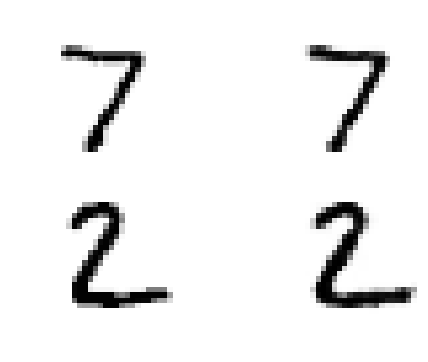

In [98]:
show_reconstructed_digits(X, outputs, "./my_model_sparse_xen.ckpt")

# 变分自动编码器

变分自动编码器的特别在于：
1. 概率自动编码器，即使经过训练，其输出也部分程度上取决运气
2. 是生成自动编码器，意味着它们可以生成看起来像是从训练样本采样的新实例

类似于RBMs，但是更容易训练，采样过程更快，而前者需要等待网络到一个热平衡状态。

In [99]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()

my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation=None)
# 编码器会产生一个随机偏差
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)

hidden3 = hidden3_mean + hidden3_sigma * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)

In [100]:
eps = 1e-10 # smoothing term to avoid computing log(0) which is NaN
# 潜在消耗，使用编码的目标分布和实际分布之间的KL散度
latent_loss = 0.5 * tf.reduce_sum(
    tf.square(hidden3_sigma) + tf.square(hidden3_mean)
    - 1 - tf.log(eps + tf.square(hidden3_sigma)))

In [101]:
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [102]:
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)
        saver.save(sess, "./my_model_variational.ckpt")

0 Train total loss: 39958.676 	Reconstruction loss: 28353.414 	Latent loss: 11605.262
1 Train total loss: 25375.598 	Reconstruction loss: 21733.613 	Latent loss: 3641.9834
2 Train total loss: 23654.398 	Reconstruction loss: 20564.06 	Latent loss: 3090.3389
3 Train total loss: 27752.012 	Reconstruction loss: 22361.094 	Latent loss: 5390.918
4 Train total loss: 20267.148 	Reconstruction loss: 17503.566 	Latent loss: 2763.5825
5 Train total loss: 21860.086 	Reconstruction loss: 18193.32 	Latent loss: 3666.765
6 Train total loss: 18534.52 	Reconstruction loss: 15682.107 	Latent loss: 2852.4124
7 Train total loss: 16879.543 	Reconstruction loss: 13967.914 	Latent loss: 2911.6284
8 Train total loss: 16603.42 	Reconstruction loss: 13677.035 	Latent loss: 2926.385
99% Train total loss: 17090.355 	Reconstruction loss: 14193.14 	Latent loss: 2897.216
10 Train total loss: 16660.32 	Reconstruction loss: 13506.295 	Latent loss: 3154.026
11 Train total loss: 17316.078 	Reconstruction loss: 14248.175

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


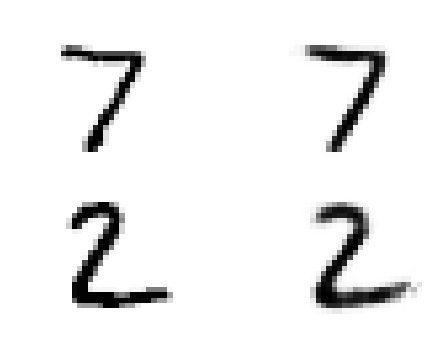

In [103]:
show_reconstructed_digits(X, outputs, "./my_model_variational.ckpt")

虽然输入可能具有复杂的分布，变分自动编码器往往会产出一个像是从简单的高斯分布中采样的编码：在训练期间，成本函数推动编码在编码空间(潜在空间)逐步迁移到看起来像是一个高斯点云的球面区域。一个重要的结果是，变分自动编码器在训练之后，可以很容易地生成一个新实例：仅仅从高斯分布中抽取随机编码，然后对其进行编码，然后调用即可。

## 生成数字

In [107]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()
my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_gamma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)
hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)
# 改进潜在消耗损失的计算
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [108]:
import numpy as np

n_digits = 60
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()                                          # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) # not shown
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)  # not shown
        saver.save(sess, "./my_model_variational.ckpt")  # not shown
    # 从高斯分布中随机采样编码
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    # 对随机采样进行解码
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

0 Train total loss: 18003.05 	Reconstruction loss: 14346.133 	Latent loss: 3656.9172
1 Train total loss: 18194.162 	Reconstruction loss: 14343.938 	Latent loss: 3850.224
2 Train total loss: 17005.06 	Reconstruction loss: 13216.932 	Latent loss: 3788.1287
3 Train total loss: 16892.434 	Reconstruction loss: 13030.703 	Latent loss: 3861.7295
4 Train total loss: 15932.771 	Reconstruction loss: 12174.719 	Latent loss: 3758.053
5 Train total loss: 15929.841 	Reconstruction loss: 12076.0 	Latent loss: 3853.8406
6 Train total loss: 16088.176 	Reconstruction loss: 12248.363 	Latent loss: 3839.8127
7 Train total loss: 16015.044 	Reconstruction loss: 12249.543 	Latent loss: 3765.501
8 Train total loss: 15657.572 	Reconstruction loss: 11883.045 	Latent loss: 3774.5273
9 Train total loss: 15613.718 	Reconstruction loss: 11818.267 	Latent loss: 3795.4514
10 Train total loss: 14970.638 	Reconstruction loss: 11325.721 	Latent loss: 3644.917
11 Train total loss: 15134.742 	Reconstruction loss: 11433.59

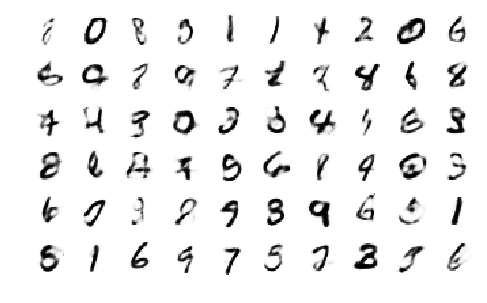

In [109]:
plt.figure(figsize=(8,50)) # not shown in the book
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])

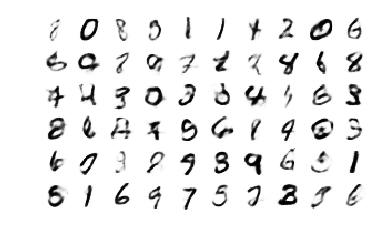

In [110]:
n_rows = 6
n_cols = 10
plot_multiple_images(outputs_val.reshape(-1, 28, 28), n_rows, n_cols)
plt.show()

In [111]:
n_digits = 3
X_test, y_test = mnist.test.next_batch(batch_size)
codings = hidden3

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    codings_val = codings.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


In [112]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    outputs_val = outputs.eval(feed_dict={codings: codings_val})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


In [114]:
X_test.shape

(150, 784)

In [113]:
outputs_val.shape

(150, 784)

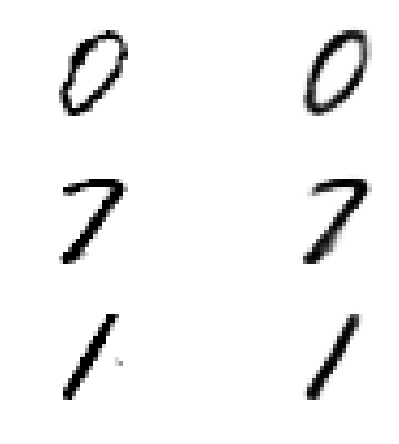

In [115]:
fig = plt.figure(figsize=(8, 2.5 * n_digits))
for iteration in range(n_digits):
    plt.subplot(n_digits, 2, 1 + 2 * iteration)
    plot_image(X_test[iteration])
    plt.subplot(n_digits, 2, 2 + 2 * iteration)
    plot_image(outputs_val[iteration])

codings_rnd -> target_codings

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


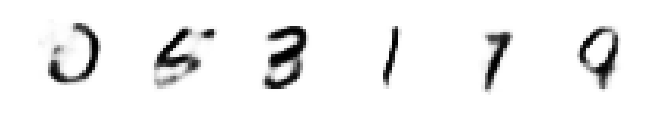

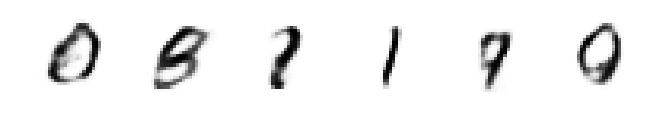

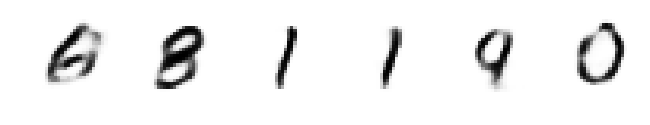

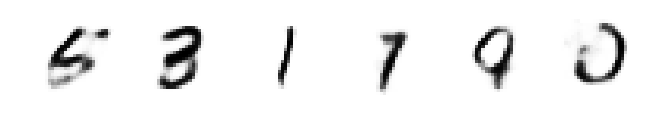

In [116]:
n_iterations = 3
n_digits = 6
codings_rnd = np.random.normal(size=[n_digits, n_hidden3])

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    target_codings = np.roll(codings_rnd, -1, axis=0)
    for iteration in range(n_iterations + 1):
        codings_interpolate = codings_rnd + (target_codings - codings_rnd) * iteration / n_iterations
        outputs_val = outputs.eval(feed_dict={codings: codings_interpolate})
        plt.figure(figsize=(11, 1.5*n_iterations))
        for digit_index in range(n_digits):
            plt.subplot(1, n_digits, digit_index + 1)
            plot_image(outputs_val[digit_index])
        plt.show()

# 其他自动编码器

# 练习